In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision as tv
import tqdm
from collections import namedtuple

In [29]:
Config = namedtuple(
    "Config",
    (
        "batch_size",
        "epochs",
        "lr",
        "lr_gamma",
        "input_size",
        "output_size",
        "w_decay",
        "r_weight",
        "load_model",
    )
)
config = Config(
    batch_size=64,
    epochs=20,
    lr=1e-4,
    lr_gamma=0.88,
    input_size=28*28,
    output_size=10,
    w_decay=1e-4,
    r_weight=0.1,
    load_model=True,
)

In [30]:
os.makedirs("./data", exist_ok=True)
mnist_train_ds = tv.datasets.MNIST(
    "./data",
    transform=tv.transforms.ToTensor(),
    train=True,
    download=True
)
mnist_test_ds = tv.datasets.MNIST(
    "./data",
    transform=tv.transforms.ToTensor(),
    train=False,
)
train_dl = torch.utils.data.DataLoader(
    mnist_train_ds,
    batch_size=config.batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=4,
)
test_dl = torch.utils.data.DataLoader(
    mnist_test_ds,
    batch_size=config.batch_size,
    shuffle=True
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
class FCNet(nn.Module):
    def __init__(self, config):
        super(FCNet, self).__init__()
        self.config = config
        self.model = nn.Sequential(
            nn.Linear(config.input_size, 128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(256, config.output_size),
        )
    
    def forward(self, x):
        print(x.shape)
        s0 = x.shape[0]
        x = x.view(s0, self.config.input_size)
        print(x.shape)
        return self.model(x)

In [24]:
def train(model, opt, criterion, config, dl, device, epoch):
    for imgs, targets in tqdm.tqdm(dl, ncols=80, desc=f"train: {epoch + 1}/{config.epochs}"):
        model.train()
        opt.zero_grad()
        imgs = imgs.to(device)
        targets = targets.to(device)
        out = model(imgs)
        loss = criterion(out, targets)
        loss.backward()
        opt.step()
        
        
def test(model, config, dl, device):
    correct = 0
    for imgs, targets in tqdm.tqdm(dl, ncols=80, desc="Test"):
        model.eval()
        imgs = imgs.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            out = model(imgs)
            pred = torch.softmax(out, 1).argmax(1)
            correct += (pred == targets).sum()
    N = len(dl.dataset)
    acc = float(correct) / N
    print(f"Test acc: {acc:.02%}")

In [160]:
model = FCNet(config).to(device)
if not config.load_model:
    opt = torch.optim.Adam(model.parameters(), config.lr, weight_decay=config.w_decay)
    sched = torch.optim.lr_scheduler.StepLR(opt, 1, config.lr_gamma)
    criterion = nn.CrossEntropyLoss()

    for ep in range(config.epochs):
        train(model, opt, criterion, config, train_dl, device, ep)
        test(model, config, test_dl, device)
        sched.step()
    torch.save(model.state_dict(), "./data/model.pt")
else:
    model.load_state_dict(torch.load("./data/model.pt"))
    test(model, config, test_dl, device)
    model = model.cpu()
    model.eval()
    print(model)

Test: 100%|██████████████████████████████████| 157/157 [00:00<00:00, 179.05it/s]

Test acc: 98.22%
FCNet(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [161]:
from scipy.optimize import Bounds, minimize

[[7 2 1 0]
 [4 1 4 9]
 [5 9 0 6]
 [9 0 1 5]]


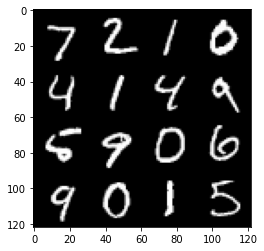

In [162]:
adv_idx = list(range(16))
adv_x = [mnist_test_ds[i][0] for i in adv_idx]
adv_labels_real = np.array([mnist_test_ds[i][1] for i in adv_idx])
grid_real = tv.utils.make_grid(adv_x, nrow=4)
plt.imshow(np.transpose(grid_real, (1, 2, 0)))
print(adv_labels_real.reshape(4, 4))

In [180]:
model = model.double()

def loss_func(xr, *args):
    x, net, c, target = args
    left = c * np.abs(x - xr).sum()
    xrt = torch.tensor(xr.reshape(1, 28, 28))
    logits = net(xrt)
    right = nn.functional.cross_entropy(logits, target).item()
    return left + right

def find_adv_r(net, x, target, c, loss_func):
    bounds = Bounds(np.zeros_like(x.ravel()), np.ones_like(x.ravel()))
    target = torch.tensor([target]).to(torch.int64)
    args = (x.flatten(), net, c, target)
    xr = x.copy()
    with torch.no_grad():
        res = opt = minimize(
            loss_func,
            xr.flatten(),
            args,
            method='L-BFGS-B',
            jac=None,
            bounds=bounds,
            tol=None,
            callback=None,
            options={
                'disp': None,
                'maxcor': 10,
                'ftol': 2.220446049250313e-09,
                'gtol': 1e-05,
                'eps': 1e-09,
                'maxfun': 25000,
                'maxiter': 25000,
                'iprint': -1,
                'maxls': 30
            }
        )
    xr = torch.tensor(res.x.reshape(x.shape)).float()
    return xr

In [181]:
xrs = [find_adv_r(model, x.numpy(), 3, 0.1, loss_func) for x in adv_x]

[[7 2 1 0]
 [4 1 4 9]
 [5 9 0 6]
 [9 0 1 5]]
[[5 2 8 0]
 [5 3 3 9]
 [0 3 0 0]
 [3 0 8 3]]


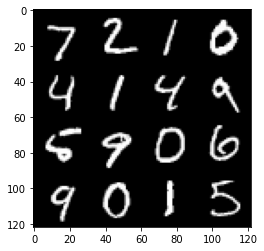

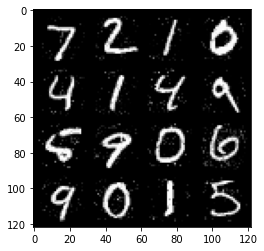

In [182]:
adv_labels_fake = []
for x in xrs:
    adv_labels_fake.append(
        torch.softmax(model(x.double()), 1).argmax().item()
    )
adv_labels_fake = np.array(adv_labels)
grid = tv.utils.make_grid(xrs, nrow=4)
plt.figure()
plt.imshow(np.transpose(grid_real, (1, 2, 0)))
plt.figure()
plt.imshow(np.transpose(grid, (1, 2, 0)))
print(adv_labels_real.reshape(4, 4))
print(adv_labels_fake.reshape(4, 4))